![insomnia](insomnia.jpg)


## 💪 Challenge

Leverage this sleep data to analyze the relationship between lifestyle, health, demographic factors, and sleep quality. Your goal is to identify factors that correlate with poor sleep health.

Some examples:

- Examine relationships between several factors like gender, occupation, physical activity, stress levels, and sleep quality/duration. Create visualizations to present your findings.
- Produce recommendations on ways people can improve sleep health based on the patterns in the data.
- Develop an accessible summary of study findings and recommendations for improving sleep health for non-technical audiences.

## ✅ Checklist before publishing into the competition

- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights. 
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error.

## 💾 The data

SleepInc has provided you with an anonymized dataset of sleep and lifestyle metrics for 374 individuals. This dataset contains average values for each person calculated over the past six months.

The dataset includes 13 columns covering sleep duration, quality, disorders, exercise, stress, diet, demographics, and other factors related to sleep health. 

| Column | Description |
|---------|----------------------------------------|  
| `Person ID` | An identifier for each individual. |
| `Gender` | The gender of the person (Male/Female). |  
| `Age` | The age of the person in years. |
| `Occupation` | The occupation or profession of the person. |
| `Sleep Duration (hours)` | The average number of hours the person sleeps per day. |
| `Quality of Sleep (scale: 1-10)` | A subjective rating of the quality of sleep, ranging from 1 to 10. |
| `Physical Activity Level (minutes/day)` | The average number of minutes the person engages in physical activity daily. |  
| `Stress Level (scale: 1-10)` | A subjective rating of the stress level experienced by the person, ranging from 1 to 10. |
| `BMI Category` | The BMI category of the person (e.g., Underweight, Normal, Overweight). |
| `Blood Pressure (systolic/diastolic)` | The average blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure. |
| `Heart Rate (bpm)` | The average resting heart rate of the person in beats per minute. |
| `Daily Steps` | The average number of steps the person takes per day. |
| `Sleep Disorder` | The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea). |

***Acknowledgments**: Laksika Tharmalingam, Kaggle: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset* (this is a fictitious dataset)

In [1]:
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt


In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import confusion_matrix


In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
df = pd.read_csv('sleep_health_data.csv')
df

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


# Clean data

## Rename columns

In [5]:
df.rename(columns=lambda c: c.lower().replace(' ', '_'), inplace=True)

In [6]:
df.columns.tolist()

['person_id',
 'gender',
 'age',
 'occupation',
 'sleep_duration',
 'quality_of_sleep',
 'physical_activity_level',
 'stress_level',
 'bmi_category',
 'blood_pressure',
 'heart_rate',
 'daily_steps',
 'sleep_disorder']

## Split 'blood_pressure'

In [7]:
df[['blood_pressure_high', 'blood_pressure_low']] = df['blood_pressure'].str.split("/", expand=True)

In [8]:
df['blood_pressure_high'] = df.loc[:, 'blood_pressure_high'].astype(int)

In [9]:
df['blood_pressure_low'] = df.loc[:, 'blood_pressure_low'].astype(int)

In [10]:
df.dtypes

person_id                    int64
gender                      object
age                          int64
occupation                  object
sleep_duration             float64
quality_of_sleep             int64
physical_activity_level      int64
stress_level                 int64
bmi_category                object
blood_pressure              object
heart_rate                   int64
daily_steps                  int64
sleep_disorder              object
blood_pressure_high          int64
blood_pressure_low           int64
dtype: object

In [11]:
df['blood_pressure_low'] = df['blood_pressure_low'].astype(int)

## Order columns

In [12]:
df = df[[
    'person_id',
    'gender',
    'age',
    'occupation',
    'sleep_duration',
    'physical_activity_level',
    'stress_level',
    'bmi_category',
    'blood_pressure_high',
    'blood_pressure_low',
    'heart_rate',
    'daily_steps',
    'sleep_disorder',
    'quality_of_sleep',
]]

In [13]:
df.sample(3)

,person_id,gender,age,occupation,sleep_duration,physical_activity_level,stress_level,bmi_category,blood_pressure_high,blood_pressure_low,heart_rate,daily_steps,sleep_disorder,quality_of_sleep
181,182,Male,42,Lawyer,7.8,90,5,Normal,130,85,70,8000,NaN,8
218,219,Male,43,Engineer,7.8,90,5,Normal,130,85,70,8000,Sleep Apnea,8
26,27,Male,30,Doctor,7.8,75,6,Normal,120,80,70,8000,NaN,7


In [14]:
df['sleep_disorder'].agg(['count', 'nunique', lambda x: x.isnull().sum()]).T\
    .rename(index={'<lambda>': 'nulls'})

count      155
nunique      2
nulls      219
Name: sleep_disorder, dtype: int64

In [15]:
df['sleep_disorder'].value_counts()

sleep_disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64

In [16]:
df['sleep_disorder'].fillna('None', inplace=True)

/tmp/ipykernel_38147/4105234030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sleep_disorder'].fillna('None', inplace=True)


In [17]:
df['sleep_disorder'].value_counts()

sleep_disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

# EDA

In [18]:
df.dtypes

person_id                    int64
gender                      object
age                          int64
occupation                  object
sleep_duration             float64
physical_activity_level      int64
stress_level                 int64
bmi_category                object
blood_pressure_high          int64
blood_pressure_low           int64
heart_rate                   int64
daily_steps                  int64
sleep_disorder              object
quality_of_sleep             int64
dtype: object

## See column's uniques

In [19]:
for col in df.select_dtypes('O').columns.tolist():
    print(
        df[col].value_counts()
    )
    print("---")
    print("")

gender
Male      189
Female    185
Name: count, dtype: int64
---

occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64
---

bmi_category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64
---

sleep_disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64
---



In [20]:
df.select_dtypes(np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
person_id,374.0,187.500000,108.108742,1.0,94.25,187.5,280.75,374.0
age,374.0,42.184492,8.673133,27.0,35.25,43.0,50.00,59.0
sleep_duration,374.0,7.132086,0.795657,5.8,6.40,7.2,7.80,8.5
physical_activity_level,374.0,59.171123,20.830804,30.0,45.00,60.0,75.00,90.0
stress_level,374.0,5.385027,1.774526,3.0,4.00,5.0,7.00,8.0
blood_pressure_high,374.0,128.553476,7.748118,115.0,125.00,130.0,135.00,142.0
blood_pressure_low,374.0,84.649733,6.161611,75.0,80.00,85.0,90.00,95.0
heart_rate,374.0,70.165775,4.135676,65.0,68.00,70.0,72.00,86.0
daily_steps,374.0,6816.844920,1617.915679,3000.0,5600.00,7000.0,8000.00,10000.0
quality_of_sleep,374.0,7.312834,1.196956,4.0,6.00,7.0,8.00,9.0


## Plot distributions

In [21]:
#df.select_dtypes(np.number).plot.hist(subplots=True, legend=False)


In [22]:
df.select_dtypes(np.number).nunique()

person_id                  374
age                         31
sleep_duration              27
physical_activity_level     16
stress_level                 6
blood_pressure_high         18
blood_pressure_low          17
heart_rate                  19
daily_steps                 20
quality_of_sleep             6
dtype: int64

In [23]:
cols = [
    'age',
    'physical_activity_level',
    'blood_pressure_high',
    'blood_pressure_low',
    'heart_rate',
]

In [24]:
cols2 = [
    #'daily_steps',
]

In [25]:
cols2 = [
    'sleep_duration',
    'stress_level',
    'quality_of_sleep',
]

array([[<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>]],
      dtype=object)

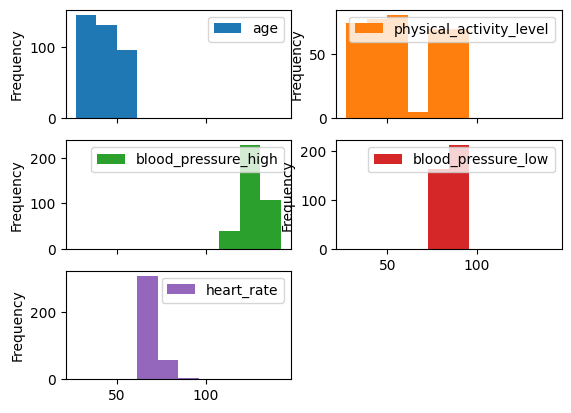

In [26]:
df[cols].plot.hist(subplots=True, legend=True, layout=(3, 2))


array([[<Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>]], dtype=object)

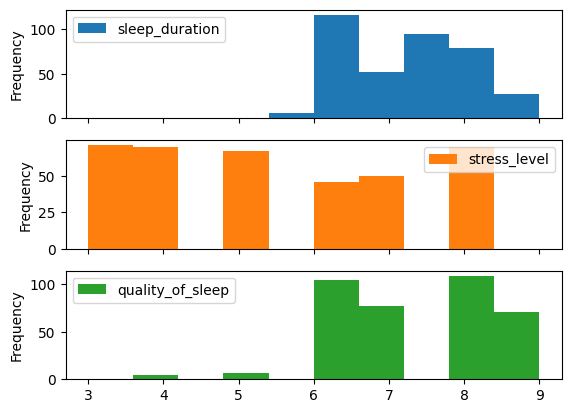

In [27]:
# https://stackoverflow.com/questions/55068880/plotting-seaborn-histogram-from-each-column-in-different-subplots-facetgrid

df[cols2].plot.hist(subplots=True, legend=True, layout=(3, 1))


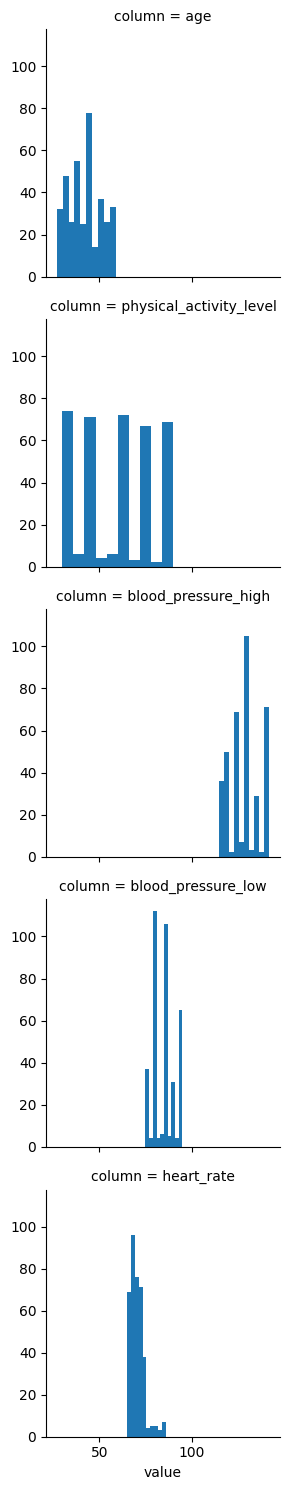

In [28]:
df_melted = df[cols].melt(var_name='column')
g = sns.FacetGrid(df_melted, row='column')
g.map(plt.hist, 'value')


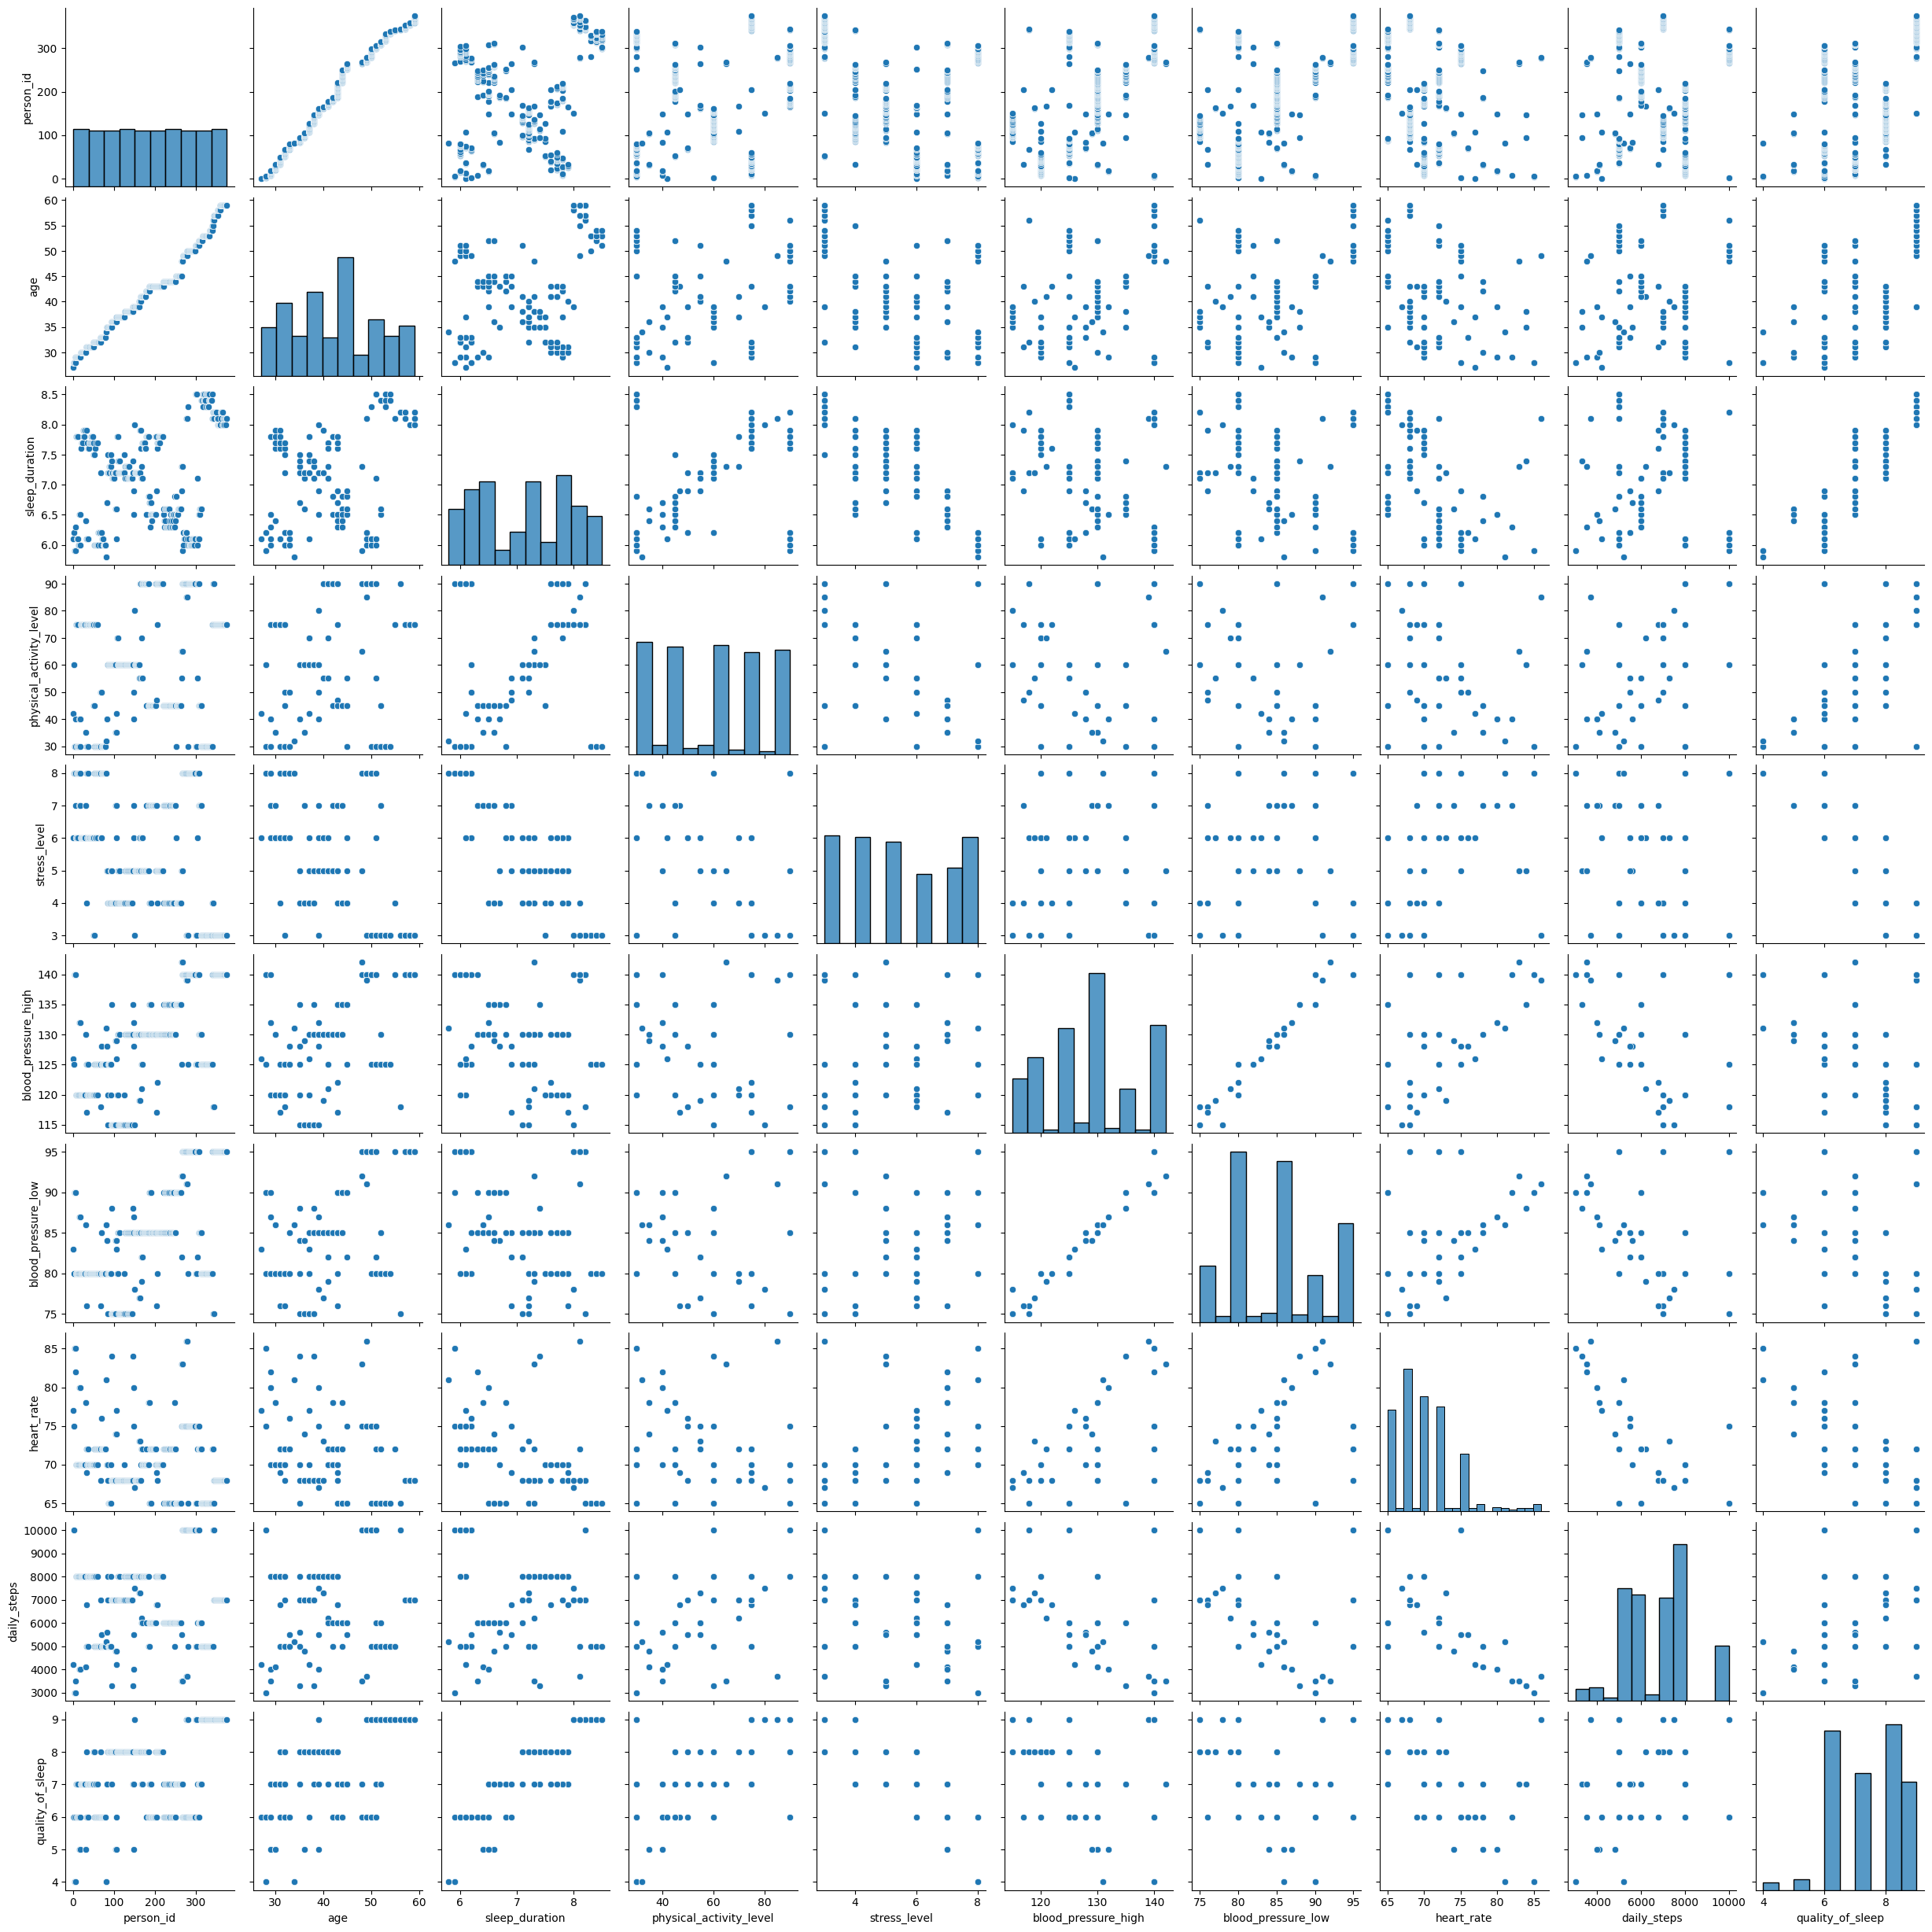

In [29]:
# https://stackoverflow.com/questions/55068880/plotting-seaborn-histogram-from-each-column-in-different-subplots-facetgrid

sns.pairplot(df.select_dtypes(np.number))

In [30]:
df.head(3).T

,0,1,2
person_id,1,2,3
gender,Male,Male,Male
age,27,28,28
occupation,Software Engineer,Doctor,Doctor
sleep_duration,6.1,6.2,6.2
physical_activity_level,42,60,60
stress_level,6,8,8
bmi_category,Overweight,Normal,Normal
blood_pressure_high,126,125,125
blood_pressure_low,83,80,80


In [31]:
df.agg(['count', 'nunique', lambda x: x.isnull().sum()]).T\
    .rename(columns={'<lambda>': 'nulls'})\
    .style.background_gradient(cmap='Blues')

,count,nunique,nulls
person_id,374,374,0
gender,374,2,0
age,374,31,0
occupation,374,11,0
sleep_duration,374,27,0
physical_activity_level,374,16,0
stress_level,374,6,0
bmi_category,374,4,0
blood_pressure_high,374,18,0
blood_pressure_low,374,17,0


##### NOTES: 
- sleep_disorder column has more than 50% of null values 
- the size of the dataset is rather samll

In [32]:
def df_info():
    temp = pd.DataFrame(index=df.columns)
    temp["Datatype"] = df.dtypes
    temp["Not null values"] = df.count()
    temp["Null values"] = df.isnull().sum()
    temp["Percentage of Null values"] = (df.isnull().mean())*100
    temp["Unique count"] = df.nunique()
    return temp

df_info()



,Datatype,Not null values,Null values,Percentage of Null values,Unique count
person_id,int64,374,0,0.0,374
gender,object,374,0,0.0,2
age,int64,374,0,0.0,31
occupation,object,374,0,0.0,11
sleep_duration,float64,374,0,0.0,27
physical_activity_level,int64,374,0,0.0,16
stress_level,int64,374,0,0.0,6
bmi_category,object,374,0,0.0,4
blood_pressure_high,int64,374,0,0.0,18
blood_pressure_low,int64,374,0,0.0,17


# Preprocess

<Axes: >

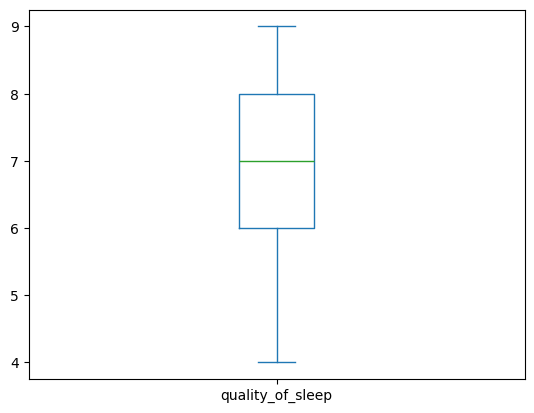

In [33]:
df['quality_of_sleep'].plot.box()

In [34]:
pd.cut(df['quality_of_sleep'], [0, 4, 6, 8, 12], labels=[1,2,3,4]).value_counts()

quality_of_sleep
3    186
2    112
4     71
1      5
Name: count, dtype: int64

In [35]:
df['quality_of_sleep_bin'] = pd.cut(df['quality_of_sleep'], [0, 4, 6, 8, 12], labels=[1,2,3,4])

In [36]:
# df['gender_bin'] = LabelEncoder().fit_transform(df['gender'])
# df['sleep_disorder_bin'] = LabelEncoder().fit_transform(df['sleep_disorder'])

In [37]:
df['gender'].value_counts().to_dict()

{'Male': 189, 'Female': 185}

In [38]:
df['gender_bin'] = df['gender'].replace({'Male': 1, 'Female': 2})

In [39]:
df['sleep_disorder'].value_counts().to_dict()

{'None': 219, 'Sleep Apnea': 78, 'Insomnia': 77}

In [40]:
df['sleep_disorder_bin'] = df['sleep_disorder'].replace({'None': 1, 'Sleep Apnea': 2, 'Insomnia': 3})

In [41]:
df['sleep_disorder_bin'] = LabelEncoder().fit_transform(df['sleep_disorder'])

In [42]:
df['occupation_bin'] = LabelEncoder().fit_transform(df['occupation'])

In [43]:
df.filter(like='bin').isnull().sum()

quality_of_sleep_bin    0
gender_bin              0
sleep_disorder_bin      0
occupation_bin          0
dtype: int64

In [44]:
df.filter(like='bin').nunique()

quality_of_sleep_bin     4
gender_bin               2
sleep_disorder_bin       3
occupation_bin          11
dtype: int64

In [45]:
df.select_dtypes('O')

,gender,occupation,bmi_category,sleep_disorder
0,Male,Software Engineer,Overweight,None
1,Male,Doctor,Normal,None
2,Male,Doctor,Normal,None
3,Male,Sales Representative,Obese,Sleep Apnea
4,Male,Sales Representative,Obese,Sleep Apnea
...,...,...,...,...
369,Female,Nurse,Overweight,Sleep Apnea
370,Female,Nurse,Overweight,Sleep Apnea
371,Female,Nurse,Overweight,Sleep Apnea
372,Female,Nurse,Overweight,Sleep Apnea


In [46]:
df.select_dtypes('O').nunique()

gender             2
occupation        11
bmi_category       4
sleep_disorder     3
dtype: int64

# Produce recommendations on ways people can improve sleep health based on the patterns in the data

In [47]:
num_cols = df.select_dtypes(include='number').drop(['person_id',], axis=1).columns.tolist()
num_cols

['age',
 'sleep_duration',
 'physical_activity_level',
 'stress_level',
 'blood_pressure_high',
 'blood_pressure_low',
 'heart_rate',
 'daily_steps',
 'quality_of_sleep',
 'gender_bin',
 'sleep_disorder_bin',
 'occupation_bin']

<Axes: >

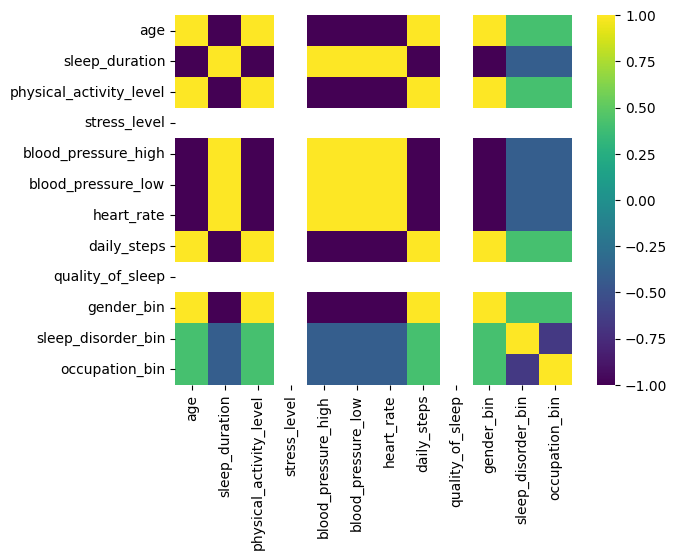

In [48]:
sns.heatmap(df.loc[
                df['quality_of_sleep_bin'] == 1,
                num_cols
            ].corr(),
            cmap='viridis'
)

<Axes: >

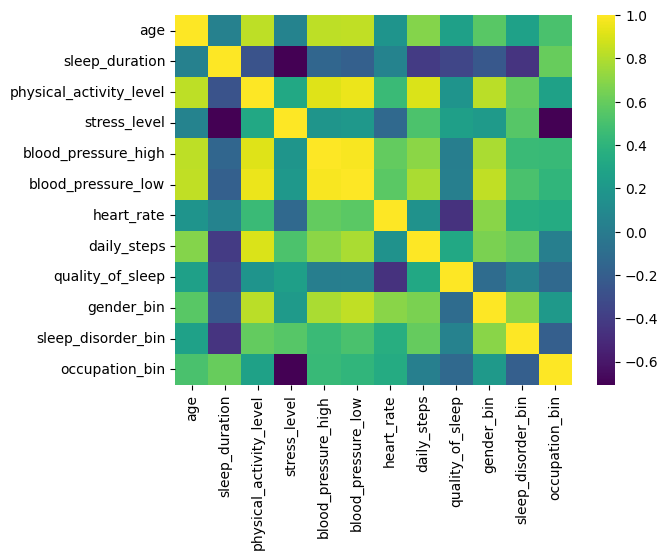

In [49]:
sns.heatmap(df.loc[
                df['quality_of_sleep_bin'] == 2,
                num_cols
            ].corr(),
            cmap='viridis'
)

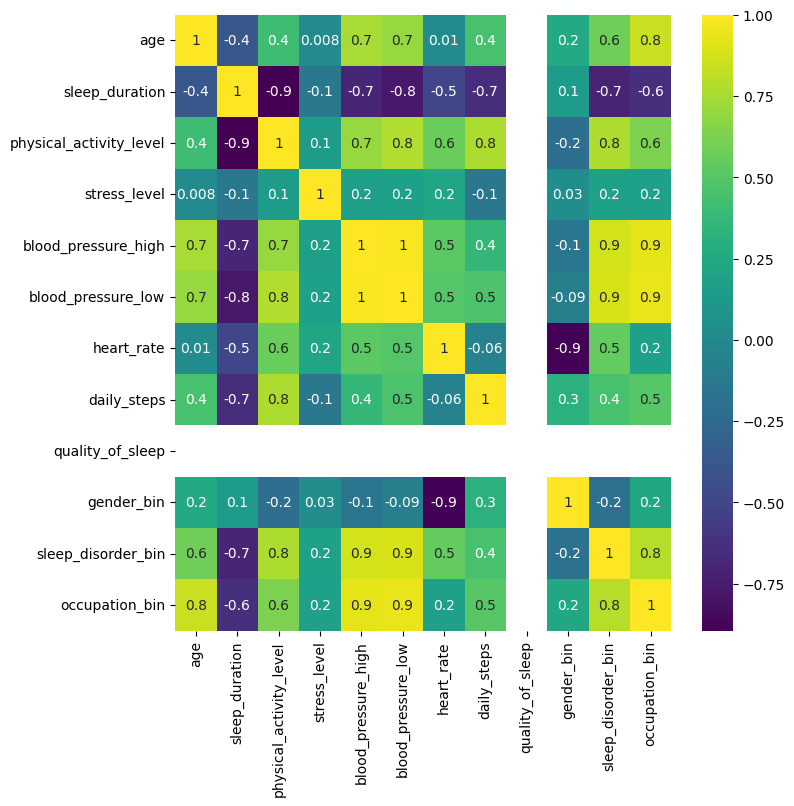

In [50]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.loc[
                df['quality_of_sleep_bin'] == 4,
                num_cols
            ].corr(),
            annot=True, fmt='.1g',
            cmap='viridis',
)
plt.show()

In [51]:
df.filter(like='sleep_disorder').value_counts()

sleep_disorder  sleep_disorder_bin
None            1                     219
Sleep Apnea     2                      78
Insomnia        0                      77
Name: count, dtype: int64

<Axes: xlabel='blood_pressure_high', ylabel='blood_pressure_low'>

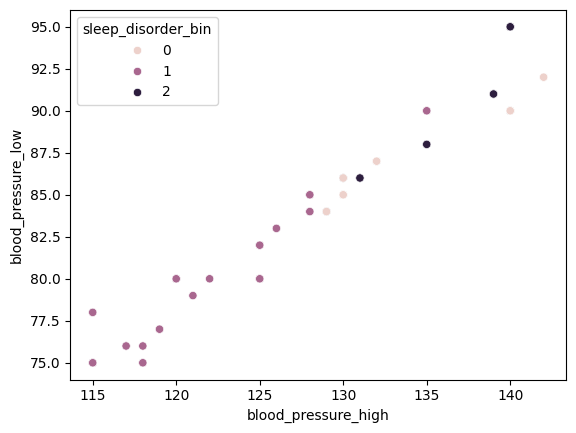

In [52]:
x='blood_pressure_high'
y='blood_pressure_low'
sns.scatterplot(data=df,
                x=x, 
                y=y, 
                hue='sleep_disorder_bin', )


<Axes: xlabel='blood_pressure_high', ylabel='blood_pressure_low'>

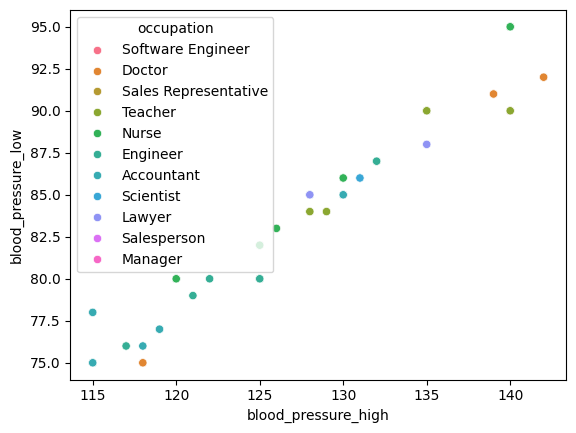

In [53]:
x='blood_pressure_high'
y='blood_pressure_low'
sns.scatterplot(data=df,
                x=x, 
                y=y, 
                hue='occupation', )


<Axes: xlabel='blood_pressure_high', ylabel='blood_pressure_low'>

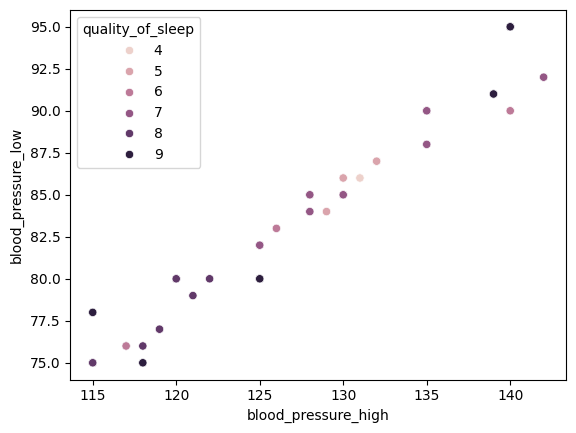

In [54]:
x='blood_pressure_high'
y='blood_pressure_low'
sns.scatterplot(data=df,
                x=x, 
                y=y, 
                hue='quality_of_sleep', )


In [ ]:
df.filter(like='bin').corr().style.background_gradient(cmap='Blues')

<Axes: xlabel='sleep_disorder', ylabel='count'>

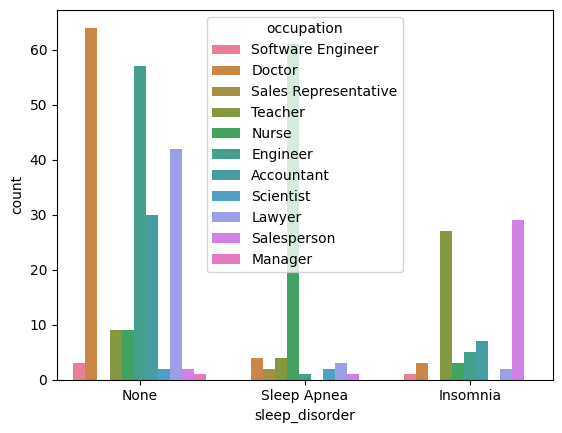

In [70]:
sns.countplot(data=df, x='sleep_disorder', hue='occupation')

In [87]:
df.groupby('sleep_disorder')['occupation'].agg(lambda x: x.value_counts().head(3).reset_index())\
    .reset_index().style.format(precision=0, thousands=".", decimal=",")

,sleep_disorder,occupation
0,Insomnia,[['Salesperson' 29] ['Teacher' 27] ['Accountant' 7]]
1,None,[['Doctor' 64] ['Engineer' 57] ['Lawyer' 42]]
2,Sleep Apnea,[['Nurse' 61] ['Doctor' 4] ['Teacher' 4]]


In [98]:
df.groupby('sleep_disorder')['occupation'].value_counts()\
    .reset_index().style.background_gradient(cmap='Blues')

,sleep_disorder,occupation,count
0,Insomnia,Salesperson,29
1,Insomnia,Teacher,27
2,Insomnia,Accountant,7
3,Insomnia,Engineer,5
4,Insomnia,Nurse,3
5,Insomnia,Doctor,3
6,Insomnia,Lawyer,2
7,Insomnia,Software Engineer,1
8,None,Doctor,64
9,None,Engineer,57


<Axes: xlabel='sleep_disorder_bin', ylabel='quality_of_sleep_bin'>

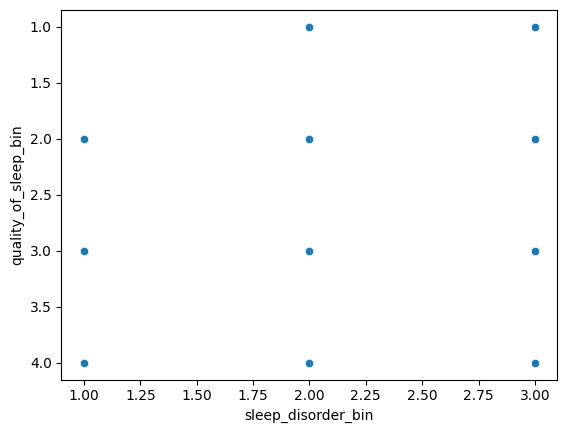

In [131]:
x='blood_pressure_high'
y='blood_pressure_low'
sns.scatterplot(data=df,
                x='sleep_disorder_bin', 
                y='quality_of_sleep_bin', )


# Preprocess

,gender,occupation,bmi_category,sleep_disorder
0,Male,Software Engineer,Overweight,NaN
1,Male,Doctor,Normal,NaN
2,Male,Doctor,Normal,NaN
3,Male,Sales Representative,Obese,Sleep Apnea
4,Male,Sales Representative,Obese,Sleep Apnea
...,...,...,...,...
369,Female,Nurse,Overweight,Sleep Apnea
370,Female,Nurse,Overweight,Sleep Apnea
371,Female,Nurse,Overweight,Sleep Apnea
372,Female,Nurse,Overweight,Sleep Apnea


In [88]:
enc = OneHotEncoder(sparse_output=False, drop='first', handle_unknown="ignore")

In [90]:
enc.fit_transform(df.select_dtypes('O')) #.set_output(transform='pandas')

array([[1., 0., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [80]:
enc.get_feature_names_out()

array(['gender_Female', 'gender_Male', 'occupation_Accountant',
       'occupation_Doctor', 'occupation_Engineer', 'occupation_Lawyer',
       'occupation_Manager', 'occupation_Nurse',
       'occupation_Sales Representative', 'occupation_Salesperson',
       'occupation_Scientist', 'occupation_Software Engineer',
       'occupation_Teacher', 'bmi_category_Normal',
       'bmi_category_Normal Weight', 'bmi_category_Obese',
       'bmi_category_Overweight', 'sleep_disorder_Insomnia',
       'sleep_disorder_Sleep Apnea', 'sleep_disorder_nan'], dtype=object)

In [75]:
enc.feature_names_in_

array(['gender', 'occupation', 'bmi_category', 'sleep_disorder'],
      dtype=object)

In [74]:
enc.categories_

[array(['Female', 'Male'], dtype=object),
 array(['Accountant', 'Doctor', 'Engineer', 'Lawyer', 'Manager', 'Nurse',
        'Sales Representative', 'Salesperson', 'Scientist',
        'Software Engineer', 'Teacher'], dtype=object),
 array(['Normal', 'Normal Weight', 'Obese', 'Overweight'], dtype=object),
 array(['Insomnia', 'Sleep Apnea', nan], dtype=object)]

In [36]:
pipeline = make_pipeline(
    one_hot_encoder
).set_output(transform="pandas")

# dft = pipeline.fit_transform(df)
dft

# Model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f49b1190550>)]))])

## Feature importance

# TODOs

- eda:cat, str, nums,...
- clean: org cols, split, dummies, clean cols
- classify, see more important features

- 